In [45]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import cartopy.crs as ccrs
from dictionaries import regions_dic, links_dic, res_potential_dic, demand_profile_dic
from pyproj import Geod
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
plt.rc("figure", figsize=(50, 50))


In [252]:
%pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 19.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


# Interconnectors

### Calculation of distances between nodes

In [46]:
# Create a Geod object for the WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Function that calculates the distance between two nodes
def calculate_distance(bus0, bus1):
    """Calculates the actual distance between two points on the earth.

    Args:
        node1 (int): Identifier of bus 0
        node2 (int): Identifier of bus 1

    Returns:
        float: Distance between the two nodes in km.
    """
    lon1, lat1 = regions_dic[bus0]["coordinates"]
    lon2, lat2 = regions_dic[bus1]["coordinates"]
    _, _, distance = geod.inv(lon1, lat1, lon2, lat2)
    return distance / 1000

# Compute the lengths of the interconnectors and store in dictionary
for link in links_dic:
    links_dic[link]["length"] = calculate_distance(links_dic[link]["bus0"][0], links_dic[link]["bus1"][0])


### Calculation of efficiency

In [47]:
def efficiency_link(P, V, rho, l):
    """Calculates the relative losses of each interconnector.

    Args:
        P (float): Power capacity of cable in MW
        V (float): Cable volatge in kV 
        rho (float): Resisitivity of cable in ohms/km
        l (float): length of cable in km

    Returns:
        float: Efficiency of the cable 
    """
    I = P / V * 1000 # Current in amperes (A)
    R = rho * l # Resistance in ohms 
    losses = I**2 * R * 1e-6 # total losses in MW
    efficiency =  1 - losses / P # Efficiency of the cable

    return efficiency

# Compute the efficiency of the interconnectors and store in dictionary
cable_capacity = 1200 # Capacity of cable in MW
cable_voltage = 1100 # Voltage of cable in kV
cable_resistivity = 0.01286 # Resistivity of the cable in ohms/km
converter_losses = 0.015 # rlative losses for the converter pair
for link in links_dic:
    links_dic[link]["efficiency"] = efficiency_link(cable_capacity, cable_voltage, cable_resistivity, links_dic[link]["length"]) - converter_losses

In [5]:
for idx, series in enumerate(deficits):    
    plt.figure(figsize=(8, 6))  # Set the figure size for better visibility
    plt.plot(series, label=f'Series {idx + 1}')
    plt.title(f'Hourly Electricity Time Series for node {idx+1}')
    plt.xlabel('Time')
    plt.ylabel('Electricity Output')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(8, 6))  # Set the figure size for better visibility
plt.plot(global_deficit, label="Global deficit")
plt.title('Hourly Electricity Time Series for 13 Profiles')
plt.xlabel('Time')
plt.ylabel('Electricity Output')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'deficits' is not defined

# PyPSA 

### Create the grid (actual grid)

In [5]:
# Initialise the network
globalgrid = pypsa.Network() 

# Loop over the dictionary to add the buses
for i in regions_dic:
    globalgrid.add(class_name = "Bus", name = regions_dic[i]["region"], v_nom=f'{cable_voltage}', carrier = "DC", v_mag_pu_set=1.0, v_mag_pu_min=0.95,v_mag_pu_max=1.05,x = regions_dic[i]["coordinates"][0] , y = regions_dic[i]["coordinates"][1]) 
    
# Loop over the dictionary to add the links
for link in links_dic:
    globalgrid.add(class_name="Link", name=links_dic[link]["name"], bus0=links_dic[link]["bus0"][1], bus1=links_dic[link]["bus1"][1], efficiency=links_dic[link]["efficiency"] , marginal_cost=0, p_min_pu=-1, p_nom_max= np.inf, p_nom_extendable=True)

# Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
for node in res_potential_dic:
    globalgrid.add(class_name="Generator", name=f'Wind {res_potential_dic[node]["name"]}', type="Wind", bus=res_potential_dic[node]["wind"], p_nom_extendable = True, p_nom_max=res_potential_dic[node]["wind_series"],p_nom_min=res_potential_dic[node]["wind_series"], marginal_cost = 0)
    globalgrid.add(class_name="Generator", name=f'PV {res_potential_dic[node]["name"]}', type="PV", bus=res_potential_dic[node]["pv"], p_nom_extendable = True, p_nom_max=res_potential_dic[node]["pv_series"],p_nom_min=res_potential_dic[node]["pv_series"], marginal_cost = 0)
    globalgrid.add(class_name="Generator", name=f'Curtailment {res_potential_dic[node]["name"]}', type="PV", bus=res_potential_dic[node]["name"], p_nom_extendable = True, marginal_cost = 10000)


# Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
for node in demand_profile_dic:
    globalgrid.add(class_name="Load", name=f"{demand_profile_dic[node]["name"]}", bus=demand_profile_dic[node]["name"], p_set=demand_profile_dic[node]["demand_series"])
    

### Create a grid with example data

In [4]:
np.random.seed(42)
time_series = pd.date_range("2023-01-01 00:00", "2023-12-31 23:00", freq="h")
def test_series(lower, upper, time_series):
    random_data = np.random.uniform(lower, upper, size=8760)
    return pd.Series(random_data, index=time_series)

# Generate 13 series
demand_test_list = [test_series(30, 100, time_series) for _ in range(14)]
wind_test_list = [test_series(0, 150, time_series) for _ in range(14)]
pv_test_list = [test_series(0, 150, time_series) for _ in range(14)]

deficits = []

for i in range(14):
    deficit = wind_test_list[i] + pv_test_list [i] - demand_test_list[i]
    deficits.append(deficit)

global_deficit =  pd.concat(deficits, axis=1).sum(axis=1)


In [14]:
time_series = pd.date_range("2023-01-01 00:00", "2023-12-31 23:00", freq="h")
# Initialize the network
globalgrid = pypsa.Network()
globalgrid.set_snapshots(time_series)

# Add buses
for i in regions_dic:
    globalgrid.add("Bus", name=regions_dic[i]["region"], x=regions_dic[i]["coordinates"][0], y=regions_dic[i]["coordinates"][1])

# Add links
for link in links_dic:
    globalgrid.add("Link", name=links_dic[link]["name"], bus0=regions_dic[links_dic[link]["bus0"][0]]["region"], bus1=regions_dic[links_dic[link]["bus1"][0]]["region"], efficiency=links_dic[link]["efficiency"], marginal_cost=0, p_min_pu=-1, p_nom_max=np.inf, p_nom_extendable=True)

# Add generators
for i in regions_dic:
    globalgrid.add("Generator", name=f'wind {i}', carrier="wind", bus=regions_dic[i]["region"], p_nom_extendable=True,p_nom_max=1.0, p_max_pu=wind_test_list[i-1], p_min_pu=wind_test_list[i-1], marginal_cost=0)
    globalgrid.add("Generator", name=f'pv {i}', carrier="pv", bus=regions_dic[i]["region"], p_nom_extendable=True,p_nom_max=1.0, p_max_pu=pv_test_list[i-1], p_min_pu=pv_test_list[i-1], marginal_cost=0)
    globalgrid.add("Generator", name=f'curtailment {i}',carrier="curtailment", bus=regions_dic[i]["region"], p_nom_extendable=True, marginal_cost=10000, sign=-1)

# Add loads
for i in regions_dic:
    pv_test_list
    globalgrid.add("Load", f"load {i}", bus=regions_dic[i]["region"], p_set=demand_test_list[i-1])

### Solve the optmisation problem

In [15]:
# Optimize the grid
globalgrid.optimize(solver_name="highs")

# Print the results
#print(globalgrid.generators.p_nom_opt)
print(globalgrid.generators_t.p)
# print(globalgrid.links_t.p0)
# print(globalgrid.links_t.p1)

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  8.06it/s]
INFO:linopy.io: Writing time: 4.07s
INFO:linopy.solvers:Log file at /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/highs.log.


Running HiGHS 1.7.0 (git hash: 27ccfaa): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [3e-04, 1e+02]
  Cost   [1e+04, 1e+04]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 1e+02]
Presolving model
613200 rows, 543148 cols, 1699440 nonzeros  0s
367920 rows, 543148 cols, 1208880 nonzeros  1s
122640 rows, 297868 cols, 718320 nonzeros  1s
Presolve : Reductions: rows 122640(-1086330); columns 297868(-245314); elements 718320(-2049930)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 122640(203420); Du: 0(7.44518e-08) 2s
       3950     6.6161486462e-09 Pr: 118690(156832); Du: 0(6.96628e-08) 7s
       7780     6.3202686135e-05 Pr: 114862(136281); Du: 0(5.49586e-07) 12s
      11385     1.3850244326e-04 Pr: 111259(251714); Du: 0(9.51141e-07) 17s
      15088     1.6416203161e-04 Pr: 107557(151368); Du: 0(1.1272e-06) 23s
      18970     1.8395783090e-04 Pr: 1036

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 543182 primals, 1208970 duals
Objective: 0.00e+00
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


Generator                wind 1  pv 1  curtailment 1      wind 2        pv 2  \
snapshot                                                                       
2023-01-01 00:00:00   61.895634  -0.0           -0.0   14.792704   31.167281   
2023-01-01 01:00:00   99.694596  -0.0           -0.0   62.321293   81.236770   
2023-01-01 02:00:00   29.354785  -0.0           -0.0   76.534788   13.190815   
2023-01-01 03:00:00   97.786295  -0.0           -0.0   97.338265   94.330994   
2023-01-01 04:00:00   25.944907  -0.0           -0.0   81.316756   93.685764   
...                         ...   ...            ...         ...         ...   
2023-12-31 19:00:00   34.013241  -0.0           -0.0  109.262263   58.677737   
2023-12-31 20:00:00   99.017698  -0.0           -0.0   72.049069  112.642682   
2023-12-31 21:00:00    9.245016  -0.0           -0.0   28.338355   94.684800   
2023-12-31 22:00:00  133.900312  -0.0           -0.0  143.793657   52.413124   
2023-12-31 23:00:00  132.948852  -0.0   

## Extract all the relevant values

In [16]:
result = globalgrid.generators_t.p["wind 1"]

In [48]:
year = 2023

for key, value in regions_dic.items(): # Annual (total) values
    for carrier in ["pv", "wind"]: 
        regions_dic[key][f"{carrier}_installed"] = globalgrid.generators_t.p[f"{carrier} {key}"].max() # Installed capacities for each node in MW
        regions_dic[key][f"total_{carrier}_yearly"] = globalgrid.generators_t.p[f"{carrier} {key}"].sum(axis=0) / 1e6 # Total energy generated at each node in TWh
    
    regions_dic[key][f"total_curtailment_yearly"] = globalgrid.generators_t.p[f"curtailment {key}"].sum(axis=0) / 1e6 # Curtailment at each node in TWh
    regions_dic[key][f"total_load_yearly"] = globalgrid.loads_t.p[f"load {key}"].sum(axis=0)
 
for key, value in regions_dic.items():
    for carrier in ["pv", "wind"]:
        series_g = globalgrid.generators_t.p[f"{carrier} {key}"] 
        regions_dic[key][f"mean_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).mean() # MW
        regions_dic[key][f"total_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).sum() # MWh
        regions_dic[key][f"mean_{carrier}_daily"] = series_g.groupby(series_g.index.date).mean() # MW

    series_c = globalgrid.generators_t.p[f"curtailment {key}"]
    regions_dic[key][f"mean_curtailment_daily"] = series_c.groupby(series_c.index.date).mean() # MW
    regions_dic[key][f"mean_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).mean() # MW
    regions_dic[key][f"total_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).sum() # MWh

    series_l = globalgrid.loads_t.p[f"load {key}"]
    regions_dic[key][f"mean_load_daily"] = series_l.groupby(series_l.index.date).mean() # MW
    regions_dic[key][f"mean_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).mean() # MW
    regions_dic[key][f"total_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).sum() # MWh
    
    

# Daily hourly values of specific days
dates = pd.to_datetime([f"{year}-03-21", f"{year}-06-21", f"{year}-09-21", f"{year}-12-21"])
for date in dates:
    for key, value in regions_dic.items():
        for carrier in ["pv", "wind"]:
            regions_dic[key][f"hourly_{carrier}_{date}"] = globalgrid.generators_t.p[f"{carrier} {key}"].loc[date.strftime('%Y-%m-%d')] # Generation profile for specific day

        regions_dic[key][f"hourly_load_{date}"] = globalgrid.loads_t.p[f"load {key}"].loc[date.strftime('%Y-%m-%d')] # Load profile for a specific day

        regions_dic[key][f"houtly_curtailment_{date}"] = globalgrid.generators_t.p[f"curtailment {key}"].loc[date.strftime('%Y-%m-%d')] # Curtailment profile for specific day

# Calculation of losses
for link in links_dic:
    p0 = globalgrid.links_t.p0[links_dic[link]["name"]]
    p1 = globalgrid.links_t.p1[links_dic[link]["name"]]
    losses = abs(p0 - p1)
    
    links_dic[link]["hourly_losses"] = losses
    links_dic[link]["monthly_losses"] = losses.groupby(losses.index.to_period('M')).sum()
    links_dic[link]["total_losses"] = losses.sum(axis=0) 

total_hourly_losses = pd.Series(0, index=globalgrid.snapshots)
for link in links_dic:
    total_hourly_losses += links_dic[link]["hourly_losses"]
daily_losses = total_hourly_losses.groupby(total_hourly_losses.index.date).sum()
mean_losses = total_hourly_losses.mean()
std_losses = total_hourly_losses.std()


In [ ]:
flow = pd.Series(10, index=globalgrid.branches().index)

In [74]:
gen = globalgrid.generators.assign(g=globalgrid.generators_t.p.mean()).groupby(["bus", "carrier"]).g.sum()
transmission = globalgrid.links.assign(g=globalgrid.links_t.p0.mean()).groupby(["Link"]).g.sum()

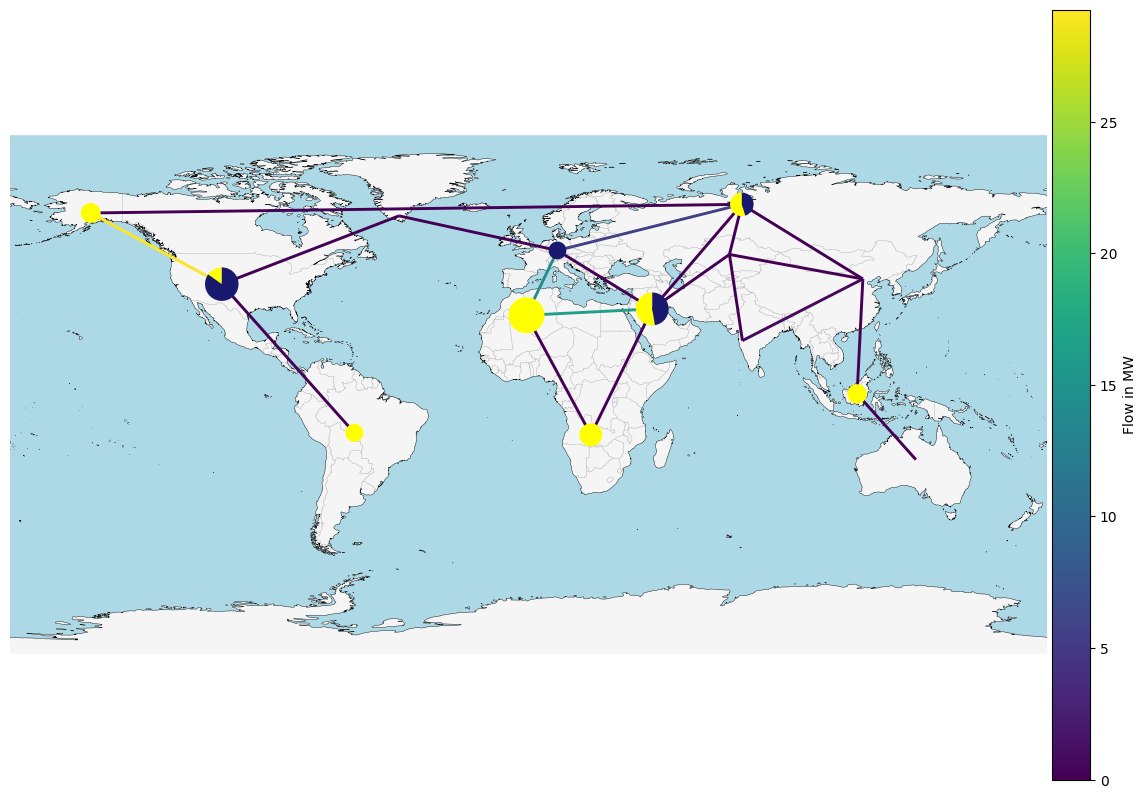

In [169]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mcolors


# Plot the network with arrows indicating flow direction
collection = globalgrid.plot(
    bus_sizes=gen / 5,
    bus_colors={"wind": "midnightblue", "pv": "yellow", "curtailment": "red"},
    flow=flow,
    line_widths=2.7,
    link_widths=2.1,
    color_geomap=True,
    link_colors=globalgrid.links_t.p0.mean().abs(),
    boundaries=[-180, 180, -90, 90],
)
# Add colorbar for flow
plt.colorbar(collection[2], fraction=0.04, pad=0.004, label="Flow in MW")

plt.show()


## Plotting of just the map

/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_88499/879127582.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


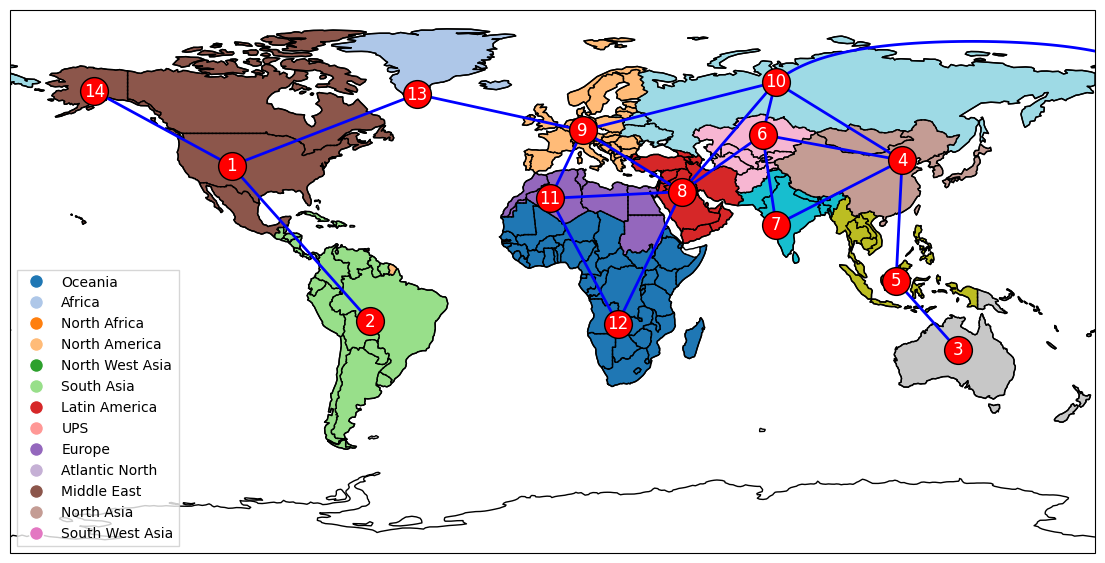

In [212]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Geod
import geopandas as gpd
from cartopy.geodesic import Geodesic

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = value["region"]

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot country regions without legend
world.plot(ax=ax, column='bus', cmap='tab20', legend=False, edgecolor='black', transform=ccrs.PlateCarree())

# Create a custom legend
unique_regions = world['bus'].dropna().unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=10, label=region) for i, region in enumerate(unique_regions)]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

for i, bus in enumerate(globalgrid.buses.index, start=1):
    x, y = globalgrid.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=400, color='red', edgecolor='k', zorder=5)
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

# Define the Geod object for WGS84
geod = Geod(ellps="WGS84")

# Plot links
for link in globalgrid.links.index:
    bus0 = globalgrid.links.loc[link, 'bus0']
    bus1 = globalgrid.links.loc[link, 'bus1']
    x0, y0 = globalgrid.buses.loc[bus0, ['x', 'y']]
    x1, y1 = globalgrid.buses.loc[bus1, ['x', 'y']]

    if link == "Alaska to UPS":  # Specifically handle the link from North America to UPS
        # Calculate points along the great circle
        points = geod.npts(x0, y0, x1, y1, 100)
        lons, lats = zip(*points)
        lons = [(lon + 360) % 360 if lon < 0 else lon for lon in lons]  # Ensure all longitudes are positive
        ax.plot(lons, lats, color='blue', linewidth=2, zorder=4)
    else:
        ax.plot([x0, x1], [y0, y1], color='blue', linewidth=2, zorder=4)


/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/ipykernel_10001/4250610060.py:25: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


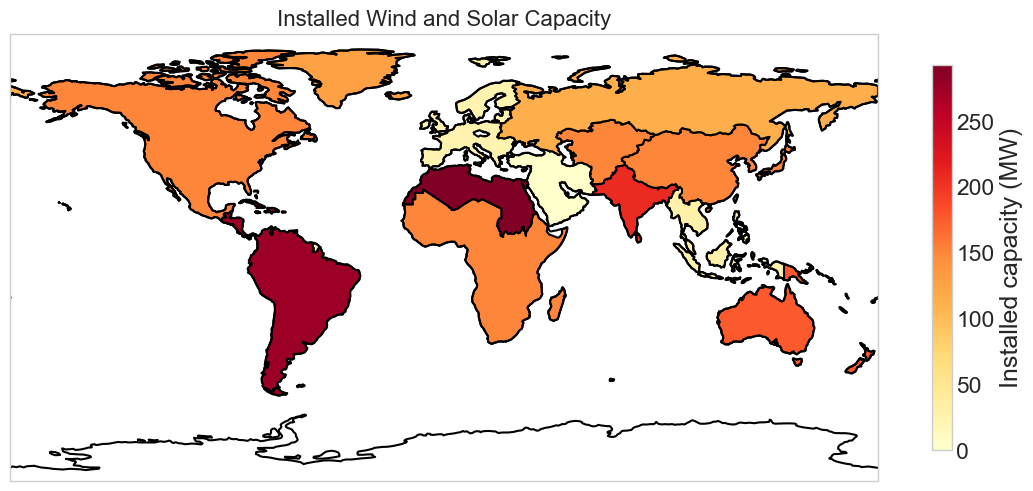

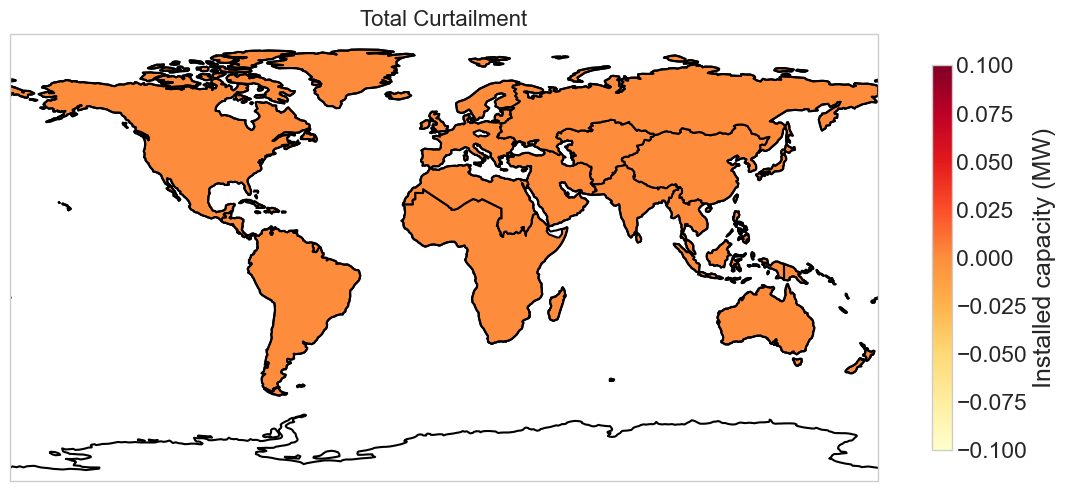

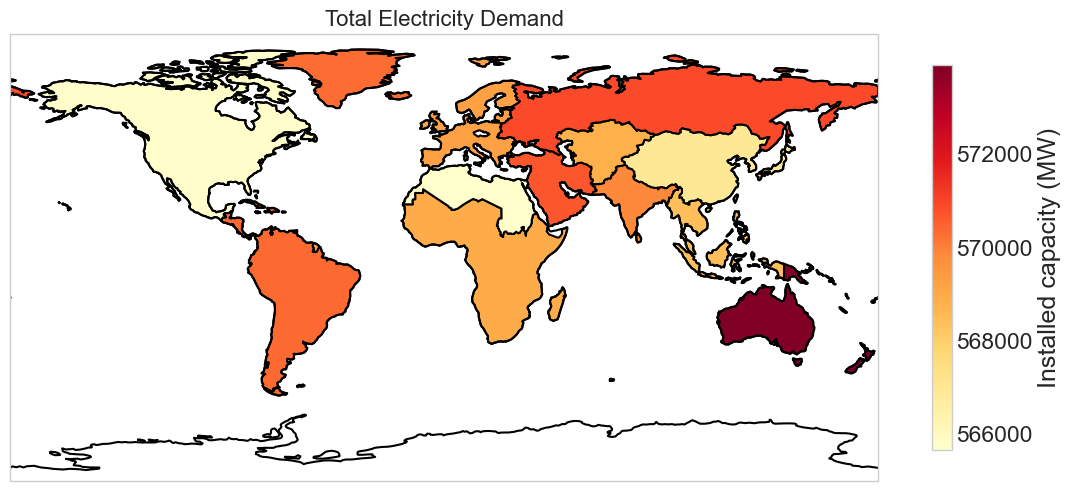

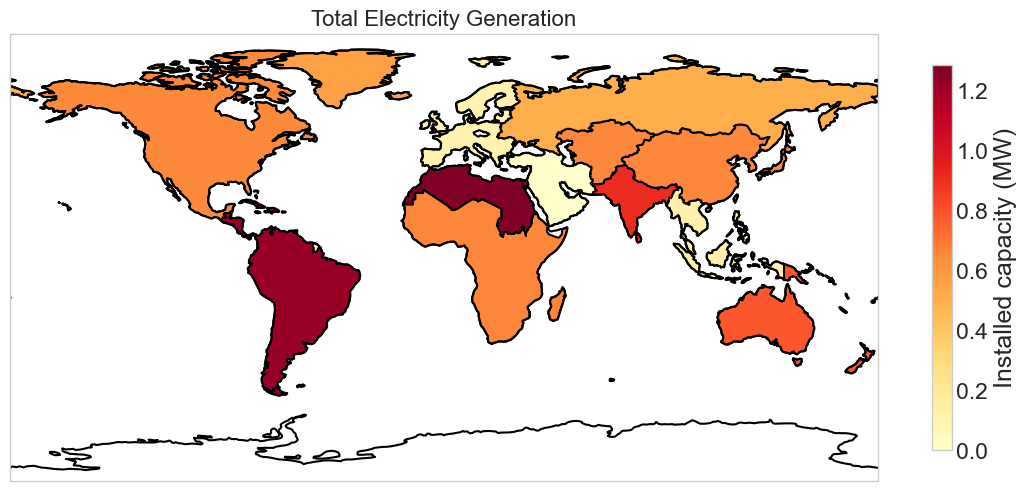

In [51]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

installed_capacity_dic = {}
curtailment_dic = {}
loads_dic = {}
generation_dic = {}
for key, value in regions_dic.items():
    installed_capacity_dic[value["region"]] = value["wind_installed"] + value["pv_installed"]
    curtailment_dic[value["region"]] = value["curtailment_total"]
    loads_dic[value["region"]] = value["load_total"] 
    generation_dic[value["region"]] = value["wind_generation_total"] + value["pv_generation_total"]
values_dics = [installed_capacity_dic, curtailment_dic, loads_dic, generation_dic]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = value["region"]

for i, values_dic in enumerate(values_dics):
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    # Plotting the network with results
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

    # Add base map features
    ax.add_feature(cfeature.COASTLINE)

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.YlOrRd

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree())

    # for i, bus in enumerate(globalgrid.buses.index, start=1):
    #     x, y = globalgrid.buses.loc[bus, ['x', 'y']]
    #     ax.scatter(x, y, s=400, color='black', edgecolor='k', zorder=5)
    #     ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

    # Add a title to the figure
    if i == 0:
        plt.title('Installed Wind and Solar Capacity', fontsize=16)
    elif i == 1:
        plt.title('Total Curtailment', fontsize=16)
    elif i == 2:
        plt.title('Total Electricity Demand', fontsize=16)
    elif i == 3:
        plt.title('Total Electricity Generation', fontsize=16)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
    cbar.set_label('Installed capacity (MW)')

    plt.show()

## Plotting of graphs


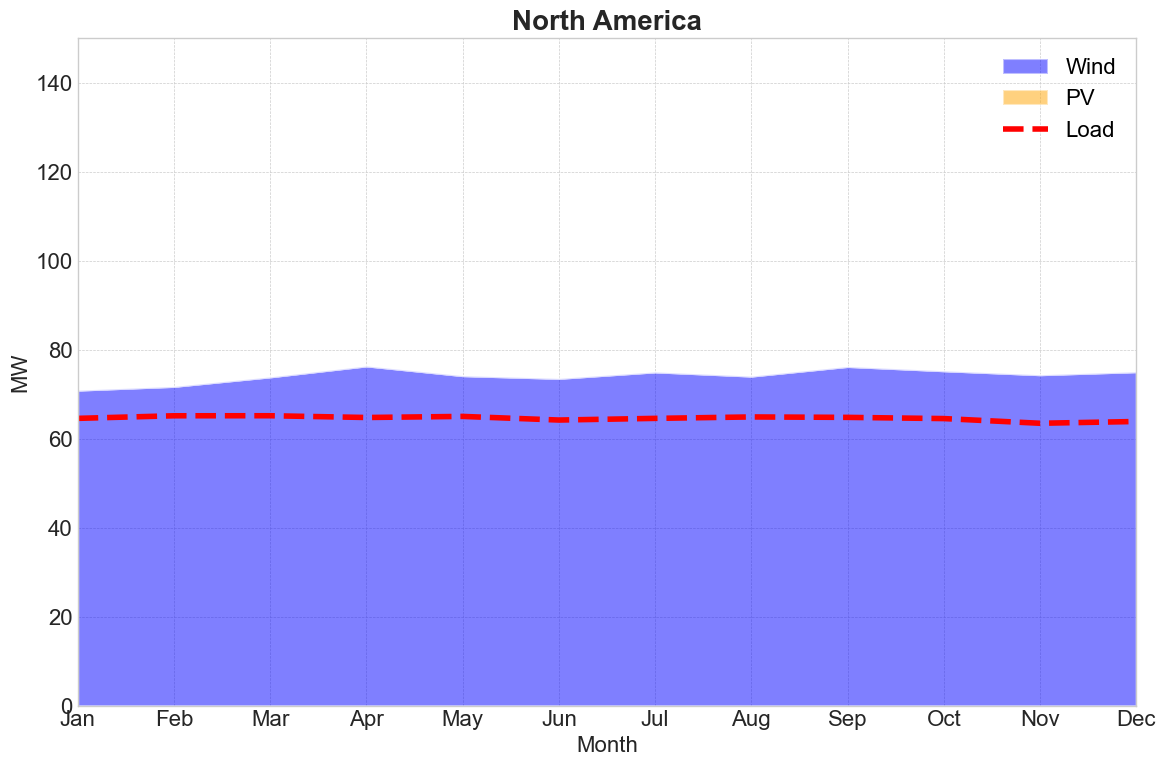

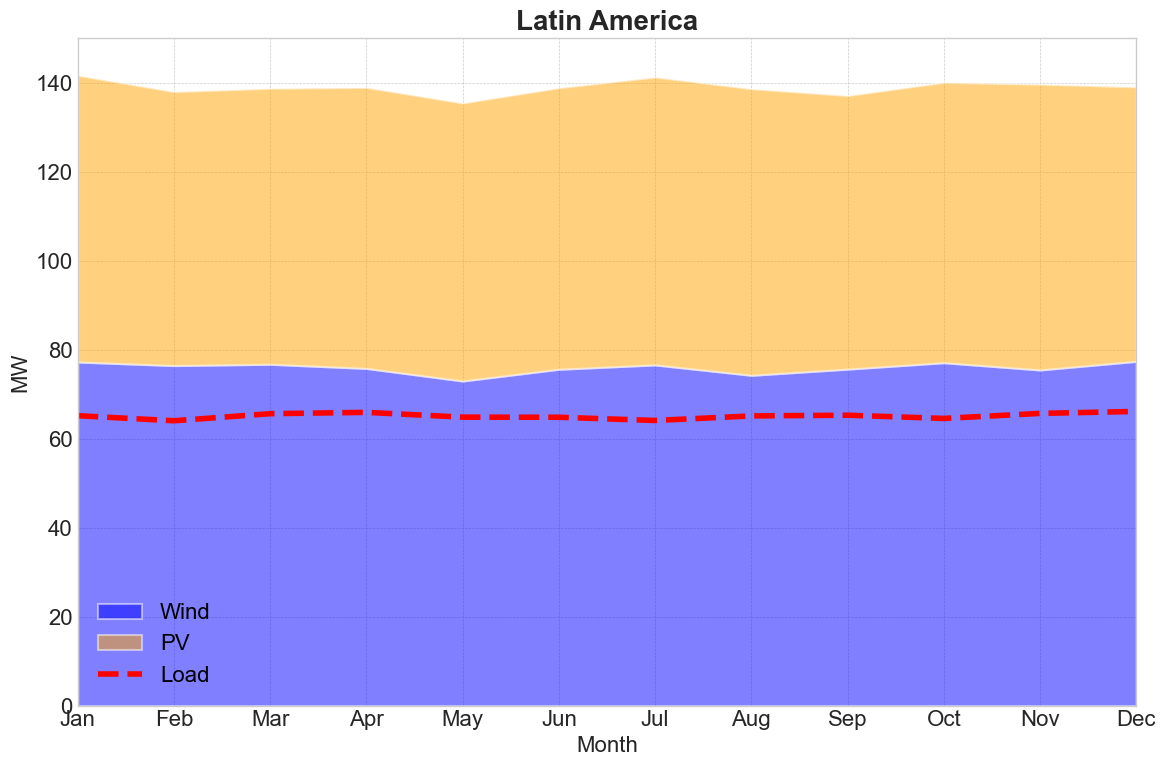

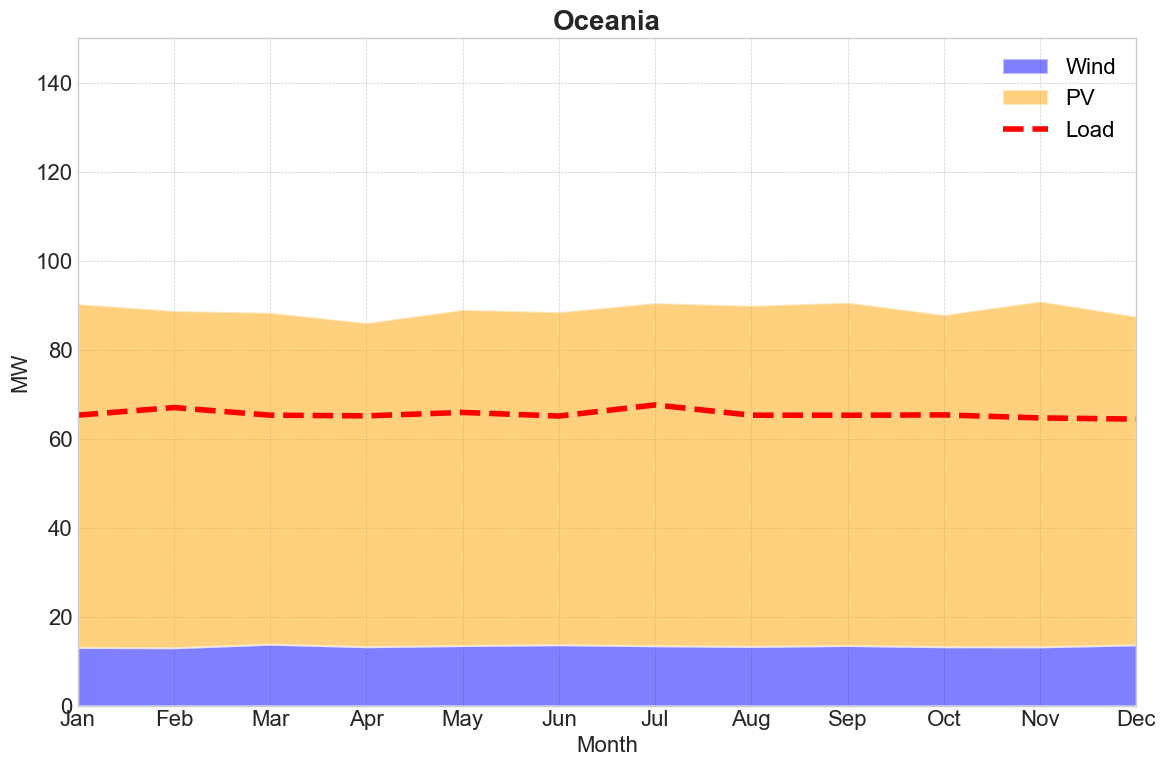

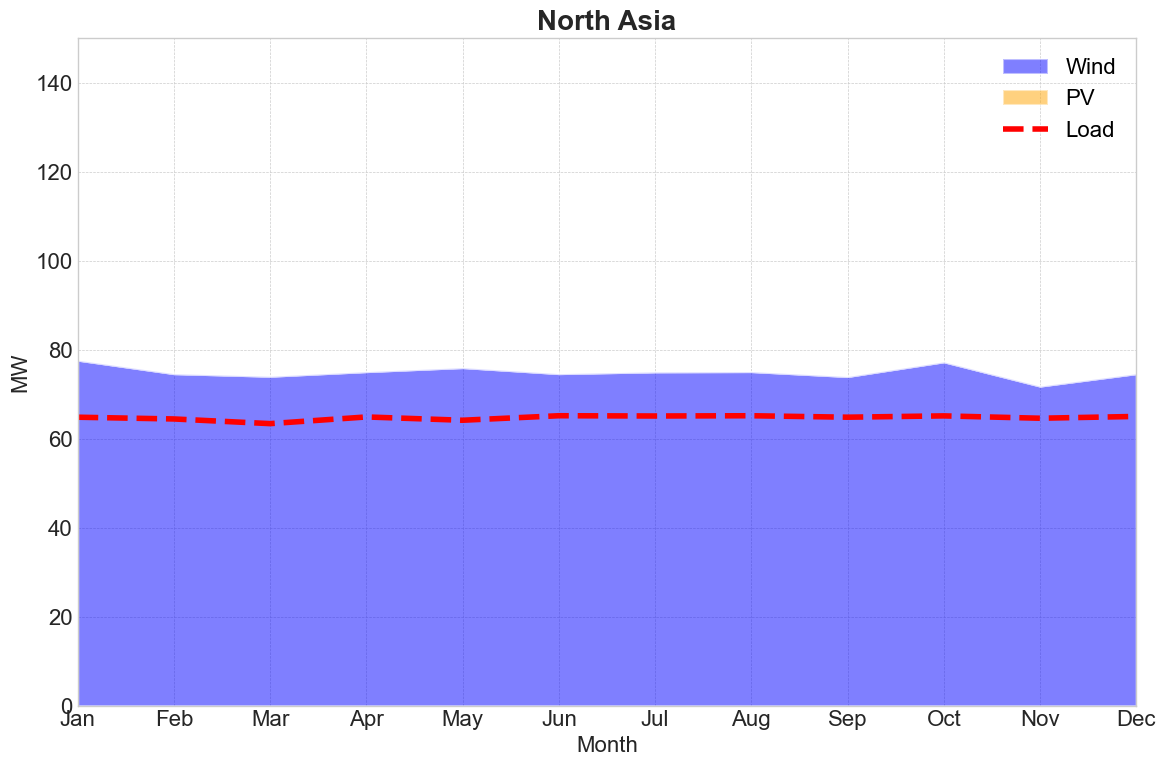

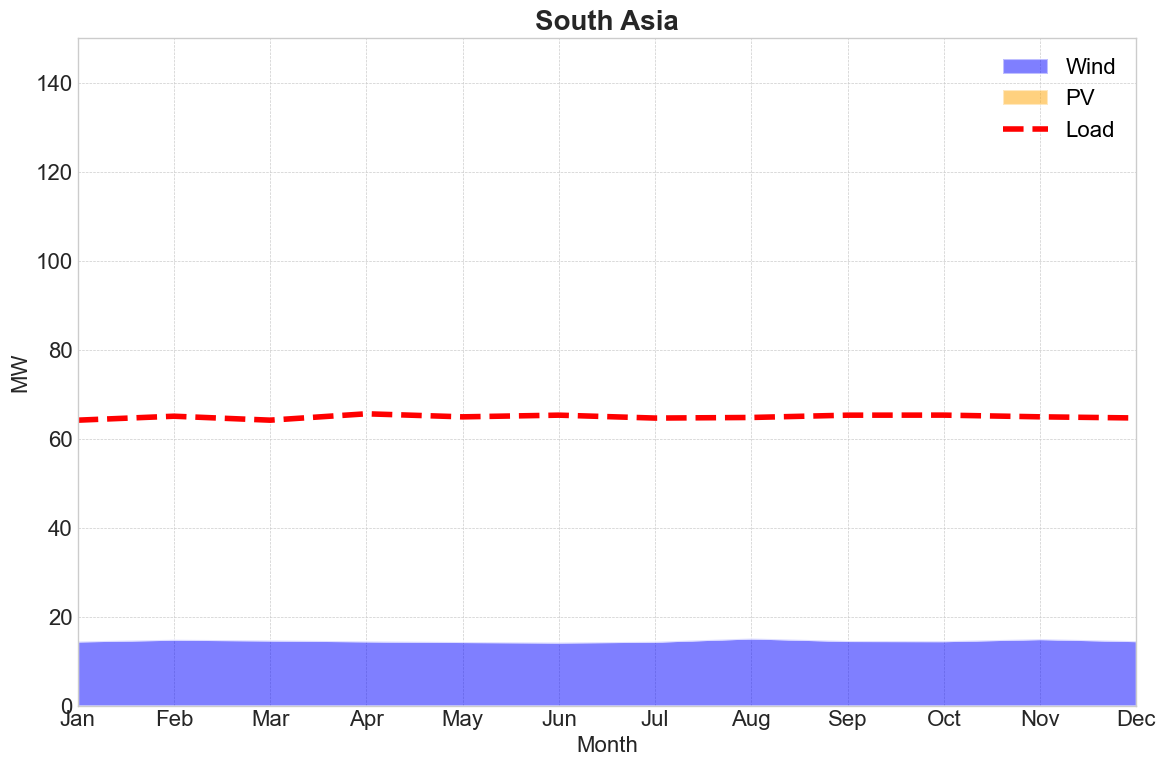

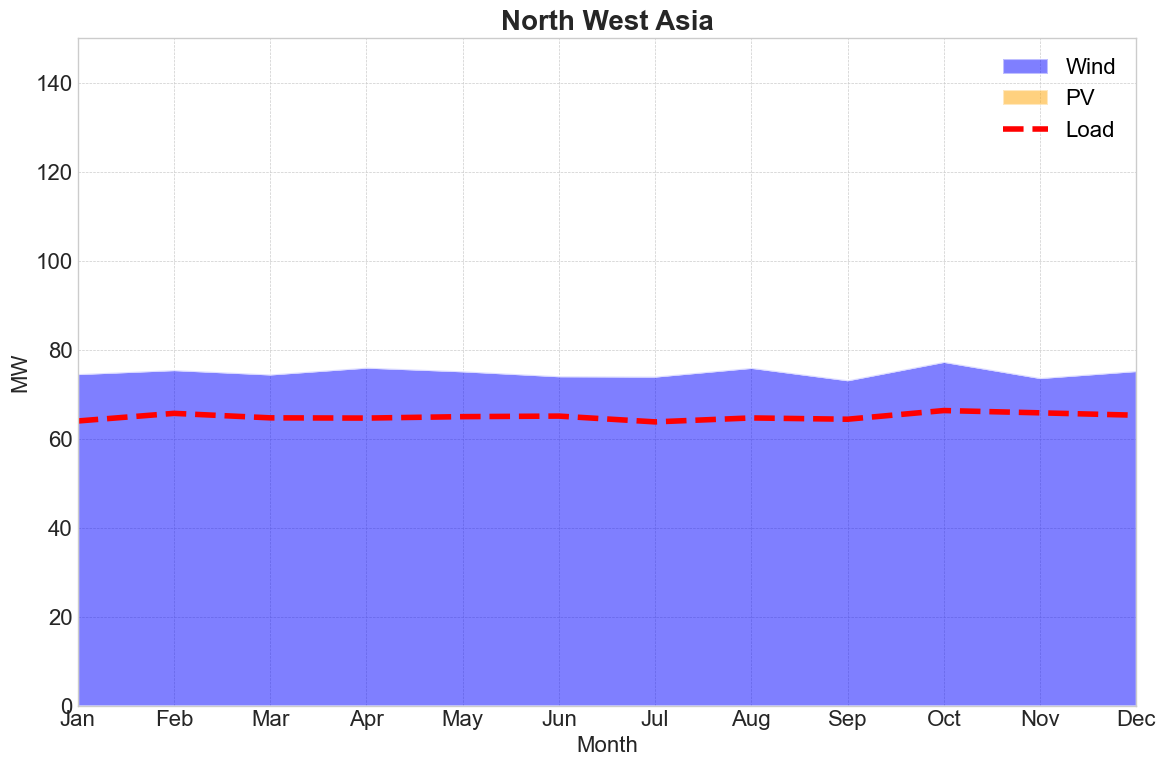

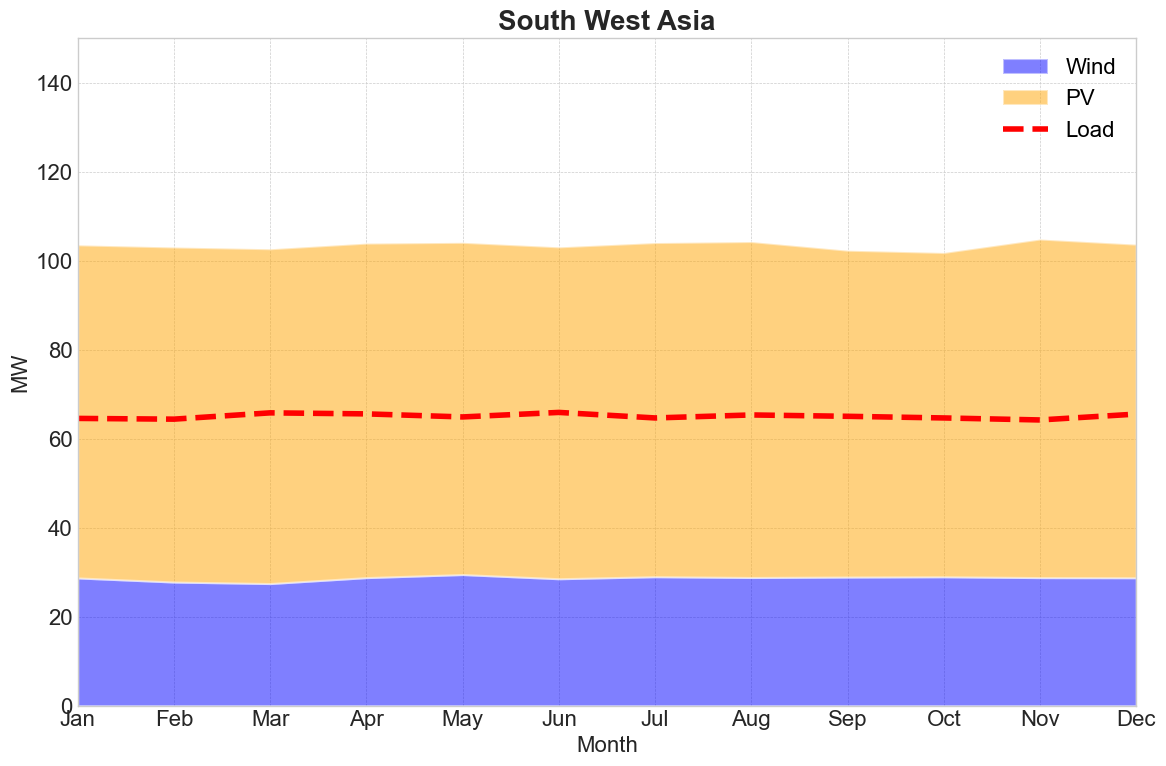

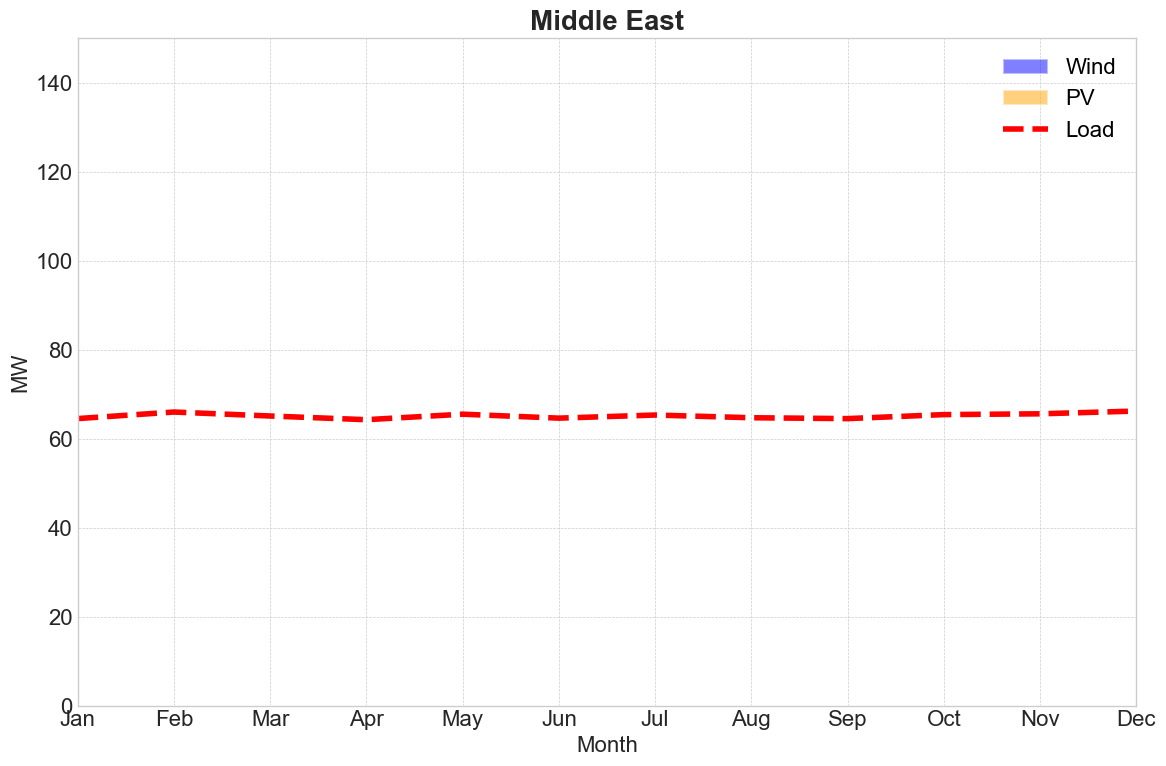

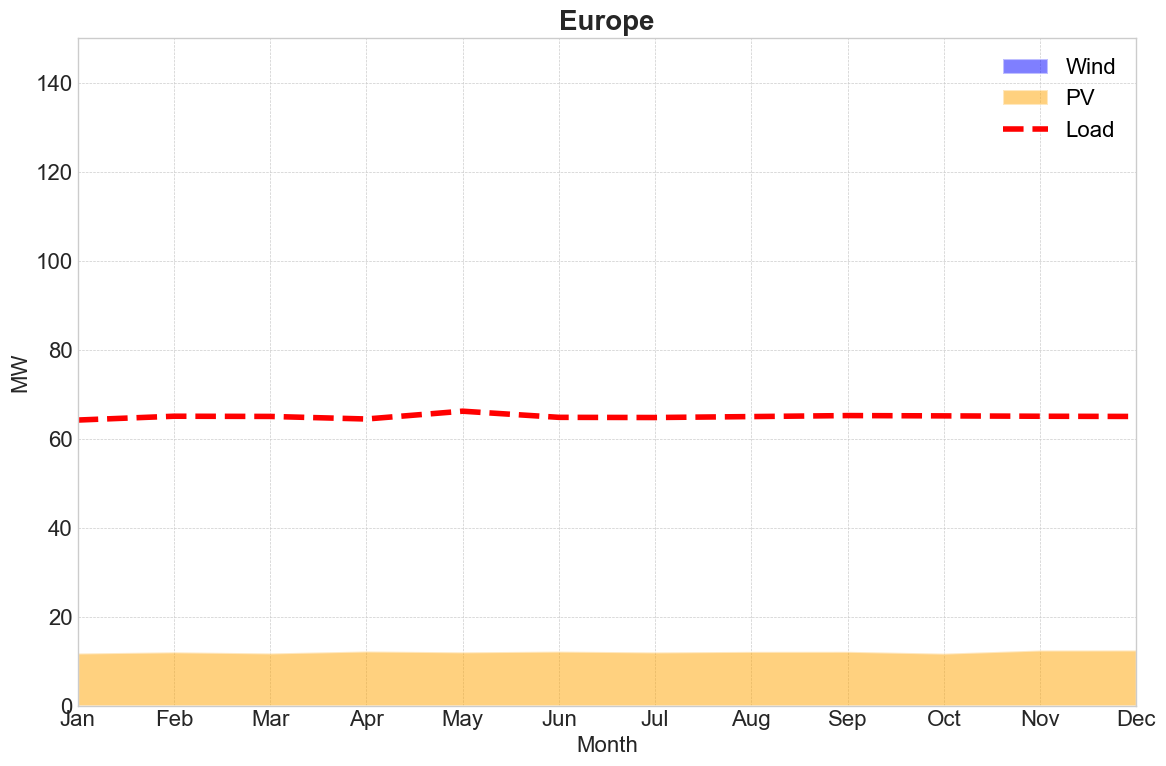

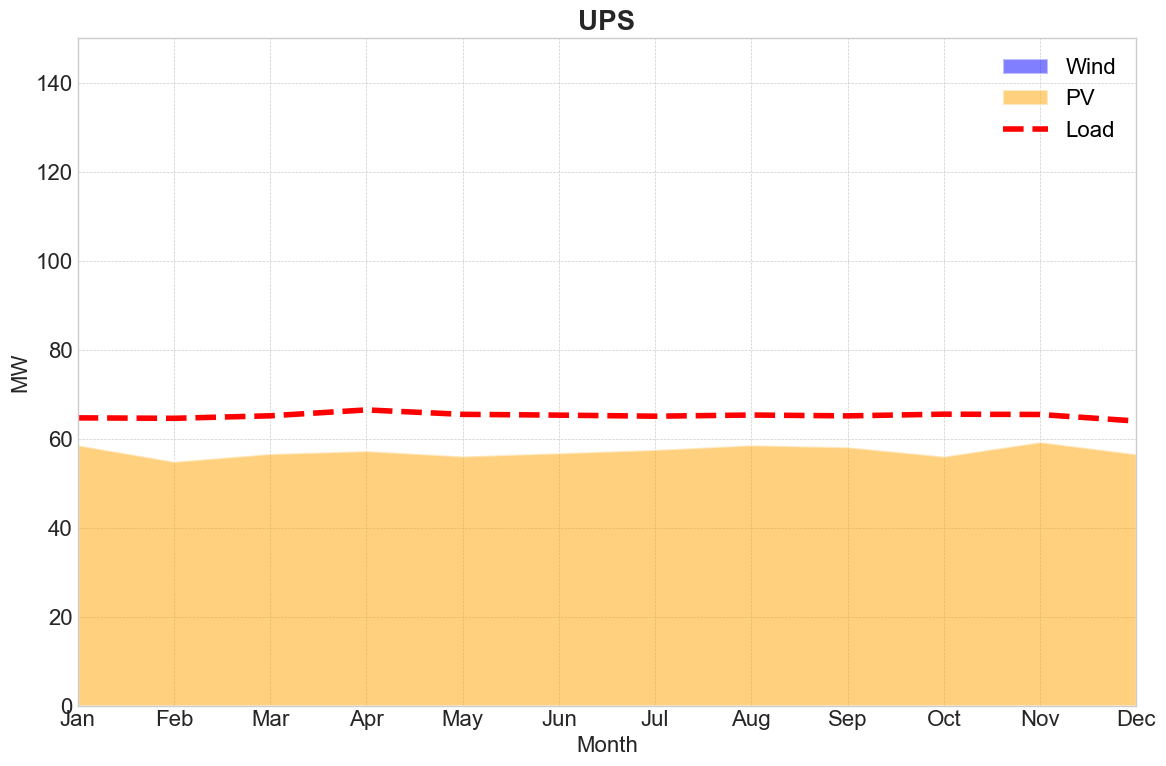

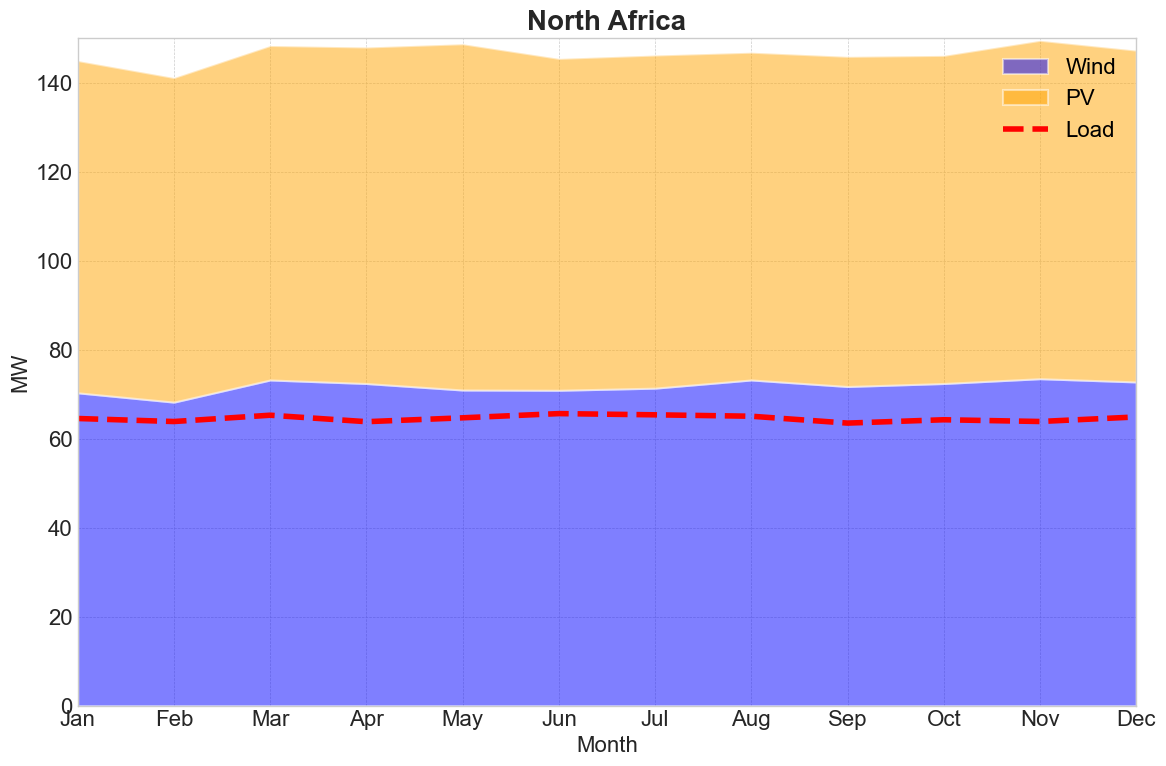

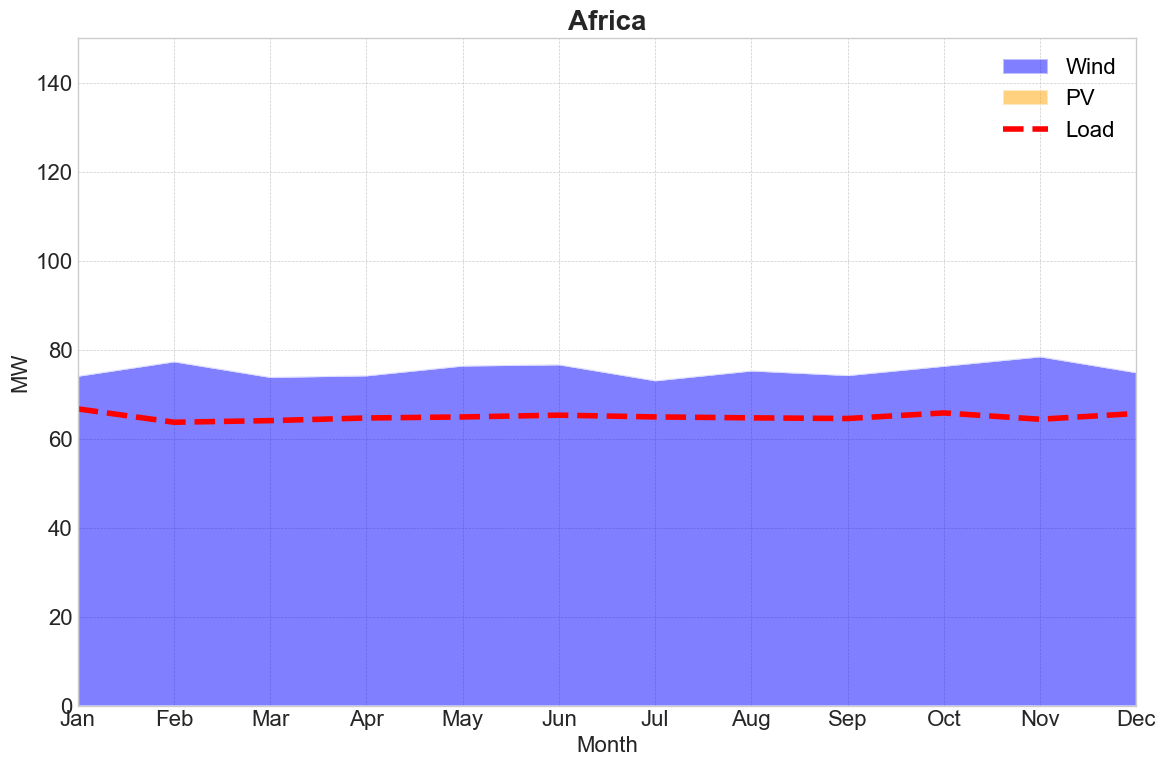

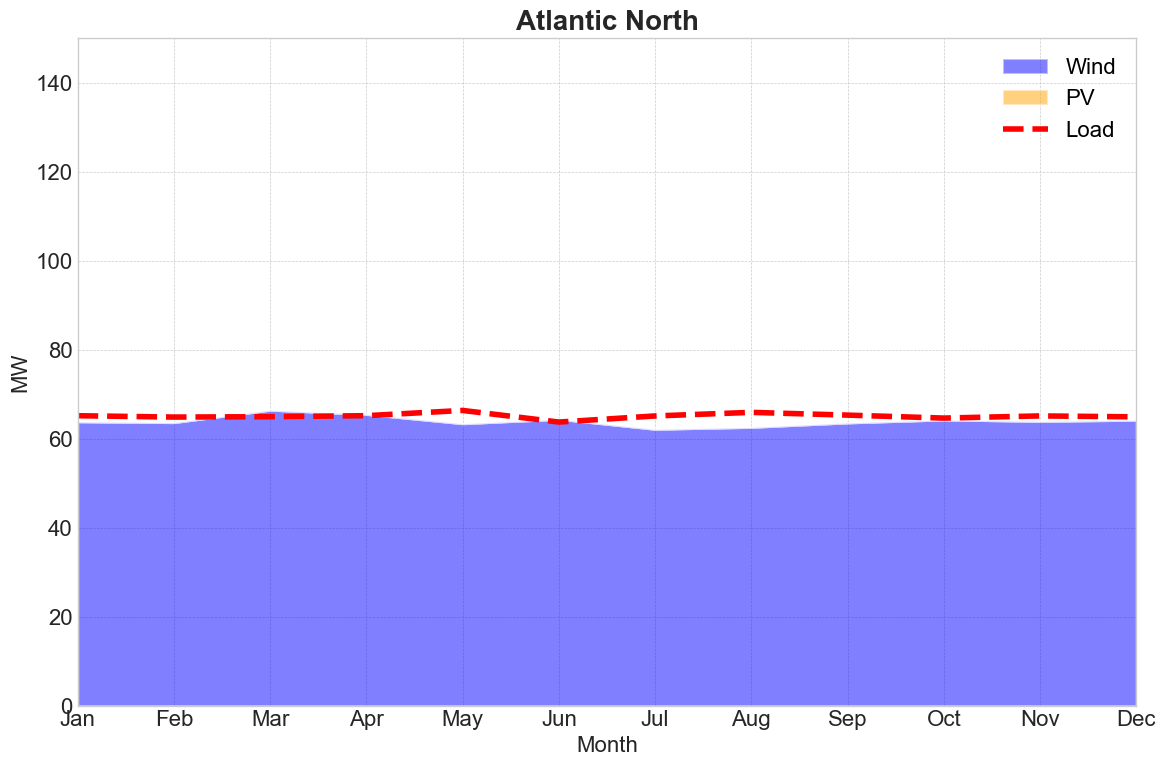

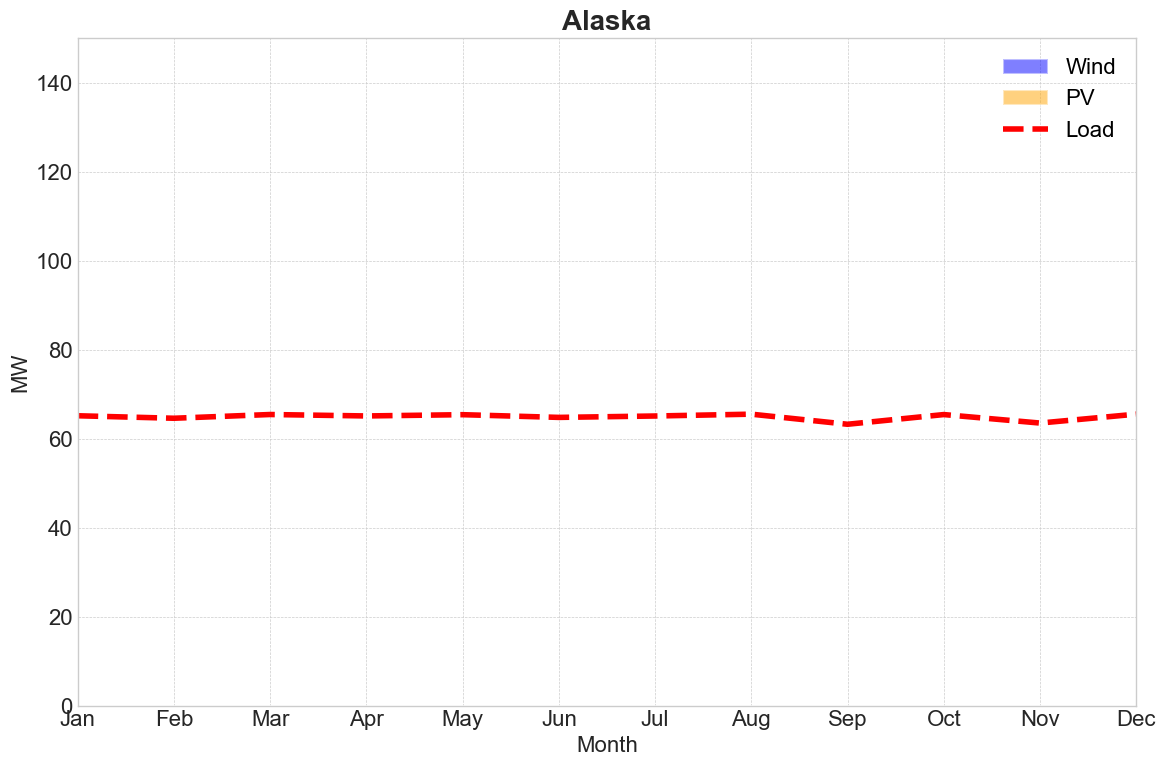

In [72]:
import matplotlib.pyplot as plt
import pandas as pd

# Set the style and context for Matplotlib
plt.style.use('seaborn-v0_8-whitegrid')  # Use a clean and white grid style

for key, value in regions_dic.items():
    load = value["mean_load_monthly"]
    wind = value["mean_wind_monthly"]
    pv = value["mean_pv_monthly"]

    # Extract values and months
    months = load.index.month
    load_values = load.values
    wind_values = wind.values
    pv_values = pv.values

    plt.figure(figsize=(12, 8))
    
    # Stacked area plot for wind and PV
    plt.stackplot(months, wind_values, pv_values, labels=['Wind', 'PV'], colors=['blue', 'orange'], alpha=0.5)
    
    # Plot load on top
    plt.plot(months, load_values, label='Load', linestyle='--', color='red', linewidth=4)
    
    plt.title(f'{value["region"]}', fontsize=20, fontweight='bold')
    plt.xlabel('Month', fontsize=16)
    plt.ylabel('MW', fontsize=16)
    legend = plt.legend(loc='best', fontsize=16)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    for text in legend.get_texts():
        text.set_color('black')  # Set legend text color to black
        #text.set_fontweight('bold')  # Make legend text bold
    plt.xlim(1,12)
    plt.ylim(0,150)
    # Customize ticks
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=16)
    plt.yticks(fontsize=16)
    
    # Tight layout to ensure everything fits without overlapping
    plt.tight_layout()
    
    
    # Show the plot
    plt.show()
